# Movies
<!-- ---
title: Gradient Considerations
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
--- -->

In [1]:
import sys, os

# spyder up to find the root
oceanbench_root = "/gpfswork/rech/cli/uvo53rl/projects/oceanbench"

# append to path
sys.path.append(str(oceanbench_root))

In [2]:
import autoroot
import typing as tp
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import kernex as kex

import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
import metpy
from sklearn.pipeline import Pipeline
from jejeqx._src.transforms.dataframe.spatial import Spherical2Cartesian
from jejeqx._src.transforms.dataframe.temporal import TimeDelta
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF


sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Processing Chain

**Part I**:

* Open Dataset
* Validate Coordinates + Variables
* Decode Time
* Select Region
* Sortby Time

**Part II**: Regrid

**Part III**:

* Interpolate Nans
* Add Units
* Spatial Rescale
* Time Rescale

**Part IV**: Metrics

*

## Data

In [3]:
# !wget wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc

In [4]:
# !cat configs/postprocess.yaml

In [5]:
# # load config
# config_dm = OmegaConf.load('./configs/postprocess.yaml')

# # instantiate
# ds = hydra.utils.instantiate(config_dm.NATL60_GF_1Y1D)
# ds

## Reference Dataset

For the reference dataset, we will look at the NEMO simulation of the Gulfstream.

In [6]:
%%time

# load config
config_dm = OmegaConf.load("./configs/postprocess.yaml")

# instantiate
ds_natl60 = hydra.utils.instantiate(config_dm.NATL60_GF_FULL).compute()
ds_natl60

CPU times: user 12.3 s, sys: 2.78 s, total: 15.1 s
Wall time: 46.7 s


<xarray.Dataset>
Dimensions:  (time: 42, lat: 600, lon: 600)
Coordinates:
  * lon      (lon) float64 -64.98 -64.97 -64.95 -64.93 ... -55.03 -55.02 -55.0
  * lat      (lat) float64 33.02 33.03 33.05 33.07 ... 42.95 42.97 42.98 43.0
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    ssh      (time, lat, lon) float32 0.6549 0.6571 0.6593 ... -0.2152 -0.2174
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

In [10]:
nadir4_config = OmegaConf.load(f"./configs/natl60_obs.yaml")
ds_nadir4 = hydra.utils.instantiate(nadir4_config.ALONGTRACK_NADIR4.data).compute()
ds_swot1nadir5 = hydra.utils.instantiate(
    nadir4_config.ALONGTRACK_SWOT1NADIR5.data
).compute()
ds_swot1nadir5

<xarray.Dataset>
Dimensions:  (time: 1003548)
Coordinates:
    lon      (time) float64 -55.03 -55.06 -55.1 -55.13 ... -59.01 -59.03 -59.05
    lat      (time) float64 39.58 39.53 39.47 39.42 ... 42.81 42.87 42.93 42.98
  * time     (time) datetime64[ns] 2012-10-22T11:16:43.687588 ... 2012-12-02T...
Data variables:
    ssh      (time) float64 0.9958 1.014 1.027 1.032 ... -0.112 -0.1122 -0.1118
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        
    title:                     Altimeter like data simulated by SWOT simulator
    keywords:                  check keywords
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-10-12T12:39:50Z
    date_modified:             2018-10-12T12:39:50Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

In [46]:

def custom_plot_ssh_together(ds, fig, tt, *args, **kwargs):
    
    sub = ds.isel(time=tt)
    
    xlim = kwargs.pop("xlim", None)
    ylim = kwargs.pop("ylim", None)
    vmin = kwargs.pop("vmin", sub.natl60.min())
    vmax = kwargs.pop("vmax", sub.natl60.max())
    cmap = kwargs.pop("cmap", "viridis")
    
    
    X, Y = np.meshgrid(ds.lon, ds.lat, indexing="ij")
    
    fig.set_size_inches(15, 5)
    
    ax = fig.subplots(ncols=3)
    
    # NATL60
    sub.natl60.plot.pcolormesh(
        ax=ax[0], 
        cmap=cmap,
        add_colorbar=False
        # vmin=vmin, vmax=vmax,
        # **kwargs
    )
    
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin,vmax)
    sub.natl60.plot.contour(
        ax=ax[0], 
        levels=levels,
        # vmin=vmin, vmax=vmax,
        alpha=0.5, linewidths=1, cmap="black",
        linestyles=np.where(levels >= 0, "-", "--")
    )
    
    # ax.set_aspect('equal')
    ax[0].set(
        xlabel="Longitude [degrees]",
        ylabel="Latitude [degrees]",
        title="NATL60"
    )
        
    # NADIR4
    pts = ax[1].scatter(
        X, Y, c=np.ma.masked_invalid(sub.nadir).T, 
        marker="s",
        s=0.25,
        vmin=vmin, vmax=vmax
    )
    ax[1].set(
        xlim=xlim, ylim=ylim,
    )
    # plt.colorbar(None, cmap="viridis", label="")
    ax[1].set(
        xlabel="Longitude [degrees]",
        ylabel="",
    )
    
    ax[1].set_title("NADIR")
    fig.tight_layout()
    
    # SWOT1NADIR5
    pts = ax[2].scatter(
        X, Y, c=np.ma.masked_invalid(sub.swot).T, 
        marker="s",
        s=0.25,
        vmin=vmin, vmax=vmax)
    ax[2].set(
        xlim=xlim, ylim=ylim,
    )
    # fig.colorbar(pts, ax=ax, location='bottom', label="SSH Anomaly [m]",  )
    # plt.colorbar(pts, cmap="viridis", , pad=0.1)
    ax[2].set(
        xlabel="Longitude [degrees]",
        ylabel="",
    )
    
    ax[2].set_title("SWOT")
    fig.tight_layout()
    return None, None

In [7]:
# ds_natl60 = ds_natl60.coarsen({"lon": 2, "lat": 2}).mean()
# ds_natl60

### Prediction Datasets 

In [8]:
%%time

experiment = "nadir" # "swot" #
if experiment == "nadir":
    # load config
    results_config = OmegaConf.load(f'./configs/results_dc20a_nadir.yaml')

    # instantiate
    ds_duacs = hydra.utils.instantiate(results_config.DUACS_NADIR.data).compute()
    ds_miost = hydra.utils.instantiate(results_config.MIOST_NADIR.data).compute()
    ds_nerf_siren = hydra.utils.instantiate(results_config.NERF_SIREN_NADIR.data).compute()
    ds_nerf_ffn = hydra.utils.instantiate(results_config.NERF_FFN_NADIR.data).compute()
    ds_nerf_mlp = hydra.utils.instantiate(results_config.NERF_MLP_NADIR.data).compute()
elif experiment == "swot":
    # load config
    results_config = OmegaConf.load(f'./configs/results_dc20a_swot.yaml')

    # instantiate
    ds_duacs = hydra.utils.instantiate(results_config.DUACS_SWOT.data).compute()
    ds_miost = hydra.utils.instantiate(results_config.MIOST_SWOT.data).compute()
    ds_nerf_siren = hydra.utils.instantiate(results_config.NERF_SIREN_SWOT.data).compute()
    ds_nerf_ffn = hydra.utils.instantiate(results_config.NERF_FFN_SWOT.data).compute()
    ds_nerf_mlp = hydra.utils.instantiate(results_config.NERF_MLP_SWOT.data).compute()

CPU times: user 178 ms, sys: 61.7 ms, total: 240 ms
Wall time: 537 ms


In [9]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/ml_ready/

nadir1.nc  nadir4.nc  nadir5.nc  swot1nadir5.nc  swot1.nc  swot.nc


## Regrdding

In [11]:
from oceanbench._src.geoprocessing.gridding import (
    grid_to_regular_grid,
    coord_based_to_grid,
)

In [12]:
ds_nadir4 = coord_based_to_grid(
    coord_based_ds=ds_nadir4.pint.dequantify(),
    target_grid_ds=ds_natl60.pint.dequantify(), 
)
ds_swot1nadir5 = coord_based_to_grid(
    coord_based_ds=ds_swot1nadir5.pint.dequantify(),
    target_grid_ds=ds_natl60.pint.dequantify(), 
)

In [13]:
ds_nadir4

<xarray.Dataset>
Dimensions:      (time: 42, lat: 600, lon: 600)
Coordinates:
  * time         (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
  * lat          (lat) float64 33.02 33.03 33.05 33.07 ... 42.97 42.98 43.0
  * lon          (lon) float64 -64.98 -64.97 -64.95 ... -55.03 -55.02 -55.0
Data variables:
    model_index  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    ssh          (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    x_al         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    ssh_obs      (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    ncycle       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    nadir_err    (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

In [15]:
%%time

ds_duacs = grid_to_regular_grid(
    src_grid_ds=ds_duacs.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_miost = grid_to_regular_grid(
    src_grid_ds=ds_miost.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_siren = grid_to_regular_grid(
    src_grid_ds=ds_nerf_siren.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_ffn = grid_to_regular_grid(
    src_grid_ds=ds_nerf_ffn.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_mlp = grid_to_regular_grid(
    src_grid_ds=ds_nerf_mlp.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)

CPU times: user 51.7 s, sys: 1.33 s, total: 53.1 s
Wall time: 53.2 s


### Preprocess Chain

In [16]:
%%time

# load config
psd_config = OmegaConf.load('./configs/metrics.yaml')

ds_natl60 = hydra.utils.instantiate(psd_config.fill_nans)(ds_natl60.pint.dequantify())
ds_duacs = hydra.utils.instantiate(psd_config.fill_nans)(ds_duacs.pint.dequantify())
ds_miost = hydra.utils.instantiate(psd_config.fill_nans)(ds_miost.pint.dequantify())
ds_nerf_siren = hydra.utils.instantiate(psd_config.fill_nans)(ds_nerf_siren.pint.dequantify())
ds_nerf_ffn = hydra.utils.instantiate(psd_config.fill_nans)(ds_nerf_ffn.pint.dequantify())
ds_nerf_mlp = hydra.utils.instantiate(psd_config.fill_nans)(ds_nerf_mlp.pint.dequantify())


CPU times: user 17.2 s, sys: 33.8 ms, total: 17.2 s
Wall time: 17.3 s


In [17]:
def correct_labels(ds):
    
    ds["lon"].attrs["units"] = "degrees"
    ds["lat"].attrs["units"] = "degrees"
    ds["ssh"].attrs["units"] = "m"
    ds["ssh"].attrs["standard_name"] = "sea_surface_height"
    ds["ssh"].attrs["long_name"] = "Sea Surface Height"
    ds["lon"].attrs["standard_name"] = "longitude"
    ds["lat"].attrs["standard_name"] = "latitude"
    ds["lat"].attrs["long_name"] = "Latitude"
    ds["lon"].attrs["long_name"] = "Longitude"
    
    return ds
    

### SSH

In [43]:
from xmovie import Movie
from pathlib import Path
from matplotlib import ticker

def custom_plot_ssh_obs(ds, fig, tt, *args, **kwargs):
    fig.set_size_inches(7, 5.5)
    
    # NATL60
    ax = fig.add_subplot(111, )
    sub = ds.ssh.isel(time=tt)
    X, Y = np.meshgrid(ds.lon, ds.lat, indexing="ij")
    pts = ax.scatter(
        X, Y, c=np.ma.masked_invalid(sub).T, 
        marker="s",
        s=0.25,
        vmin=kwargs.pop("vmin", None), 
        vmax=kwargs.pop("vmax", None))
    ax.set(
        xlim=kwargs.pop("xlim", None),
        ylim=kwargs.pop("ylim", None),
    )
    plt.colorbar(pts, cmap="viridis", label="SSH Anomaly [m]")
    ax.set(
        xlabel="Longitude [degrees]",
        ylabel="Latitude [degrees]",
    )
    # sub.plot.scatter(x="lon", y="lat", ax=ax)
    # sub.plot.pcolormesh(ax=ax, cmap="viridis", **kwargs)
    # ax.set_aspect('equal')
    
    ax.set_title(pd.to_datetime(sub.time.values).strftime('%Y-%m-%d'))
    fig.tight_layout()
    return None, None

def custom_plot_ssh(ds, fig, tt, *args, **kwargs):
    fig.set_size_inches(7, 5.5)
    ax = fig.add_subplot(111, )
    vmin = kwargs.pop("vmin", ds.min().values)
    vmax = kwargs.pop("vmax", ds.max().values)
    cmap = kwargs.pop("cmap", "viridis")
    cbar_kwargs = {"label": "SSH Anomaly [m]"}
    sub = ds.isel(time=tt)
    sub.plot.pcolormesh(
        ax=ax, 
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        cbar_kwargs=cbar_kwargs, 
        **kwargs
    )
    
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin,vmax)
    sub.plot.contour(
        ax=ax, 
        levels=levels,
        vmin=vmin, vmax=vmax,
        alpha=0.5, linewidths=1, cmap="black",
        linestyles=np.where(levels >= 0, "-", "--")
    )
    
    # ax.set_aspect('equal')
    ax.set(
        xlabel="Longitude [degrees]",
        ylabel="Latitude [degrees]",
    )
    
    ax.set_title(pd.to_datetime(sub.time.values).strftime('%Y-%m-%d'))
    fig.tight_layout()
    return None, None

def create_movie(
    var, name, plotfunc=custom_plot_ssh, framedim: str = "steps", file_path=None, **kwargs
):

    if file_path is not None:
        file_name = Path(file_path).joinpath(f"movie_{name}.gif")
    else:
        file_name = Path(f"./movie_{name}.gif")    

    mov = Movie(
        var, plotfunc=plotfunc, framedim=framedim, **kwargs,
        dpi=200, 
        input_check=False
    )
    mov.save(
        file_name,
        remove_movie=False,
        progress=True,
        framerate=3,
        gif_framerate=3,
        overwrite_existing=True,
        gif_resolution_factor=0.5,
        parallel=True,
    )

    return None

In [44]:
# NATL60
ds_natl60_mean = ds_natl60.ssh.mean(dim=["lat", "lon"])
ds_natl60_anomaly = ds_natl60.ssh - ds_natl60_mean
# NADIR4
ds_nadir_anomaly = ds_nadir4.ssh - ds_natl60_mean
# SWOT1NADIR5
ds_swot_anomaly =  ds_swot1nadir5.ssh - ds_natl60_mean

In [45]:
temp_ds = xr.Dataset(
    {"natl60": ds_natl60_anomaly},)
temp_ds["nadir"] = ds_nadir_anomaly
temp_ds["swot"] = ds_swot_anomaly
temp_ds

<xarray.Dataset>
Dimensions:  (lon: 600, lat: 600, time: 42)
Coordinates:
  * lon      (lon) float64 -64.98 -64.97 -64.95 -64.93 ... -55.03 -55.02 -55.0
  * lat      (lat) float64 33.02 33.03 33.05 33.07 ... 42.95 42.97 42.98 43.0
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    natl60   (time, lat, lon) float32 0.2225 0.2248 0.227 ... -0.6282 -0.6304
    nadir    (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    swot     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [47]:
xlim = [ds_natl60.lon.min().values, ds_natl60.lon.max().values]
ylim = [ds_natl60.lat.min().values, ds_natl60.lat.max().values]
vmin = ds_natl60.ssh.min().values
vmax = ds_natl60.ssh.max().values


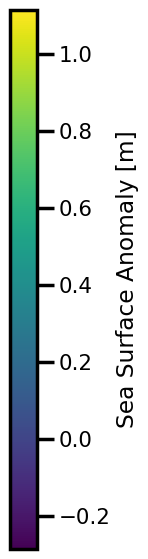

In [48]:

fig, ax = plt.subplots(figsize=(5,7))
img = ax.imshow(ds_natl60.ssh.isel(time=0))
plt.gca().set_visible(False)
fig.colorbar(
    img, cmap="viridis", 
    label="Sea Surface Anomaly [m]", 
    orientation="vertical",
)
# plt.tight_layout()
plt.show()
# plt.colorbar(orientation="horizontal", cax=cax)
# pl.savefig("colorbar.pdf")

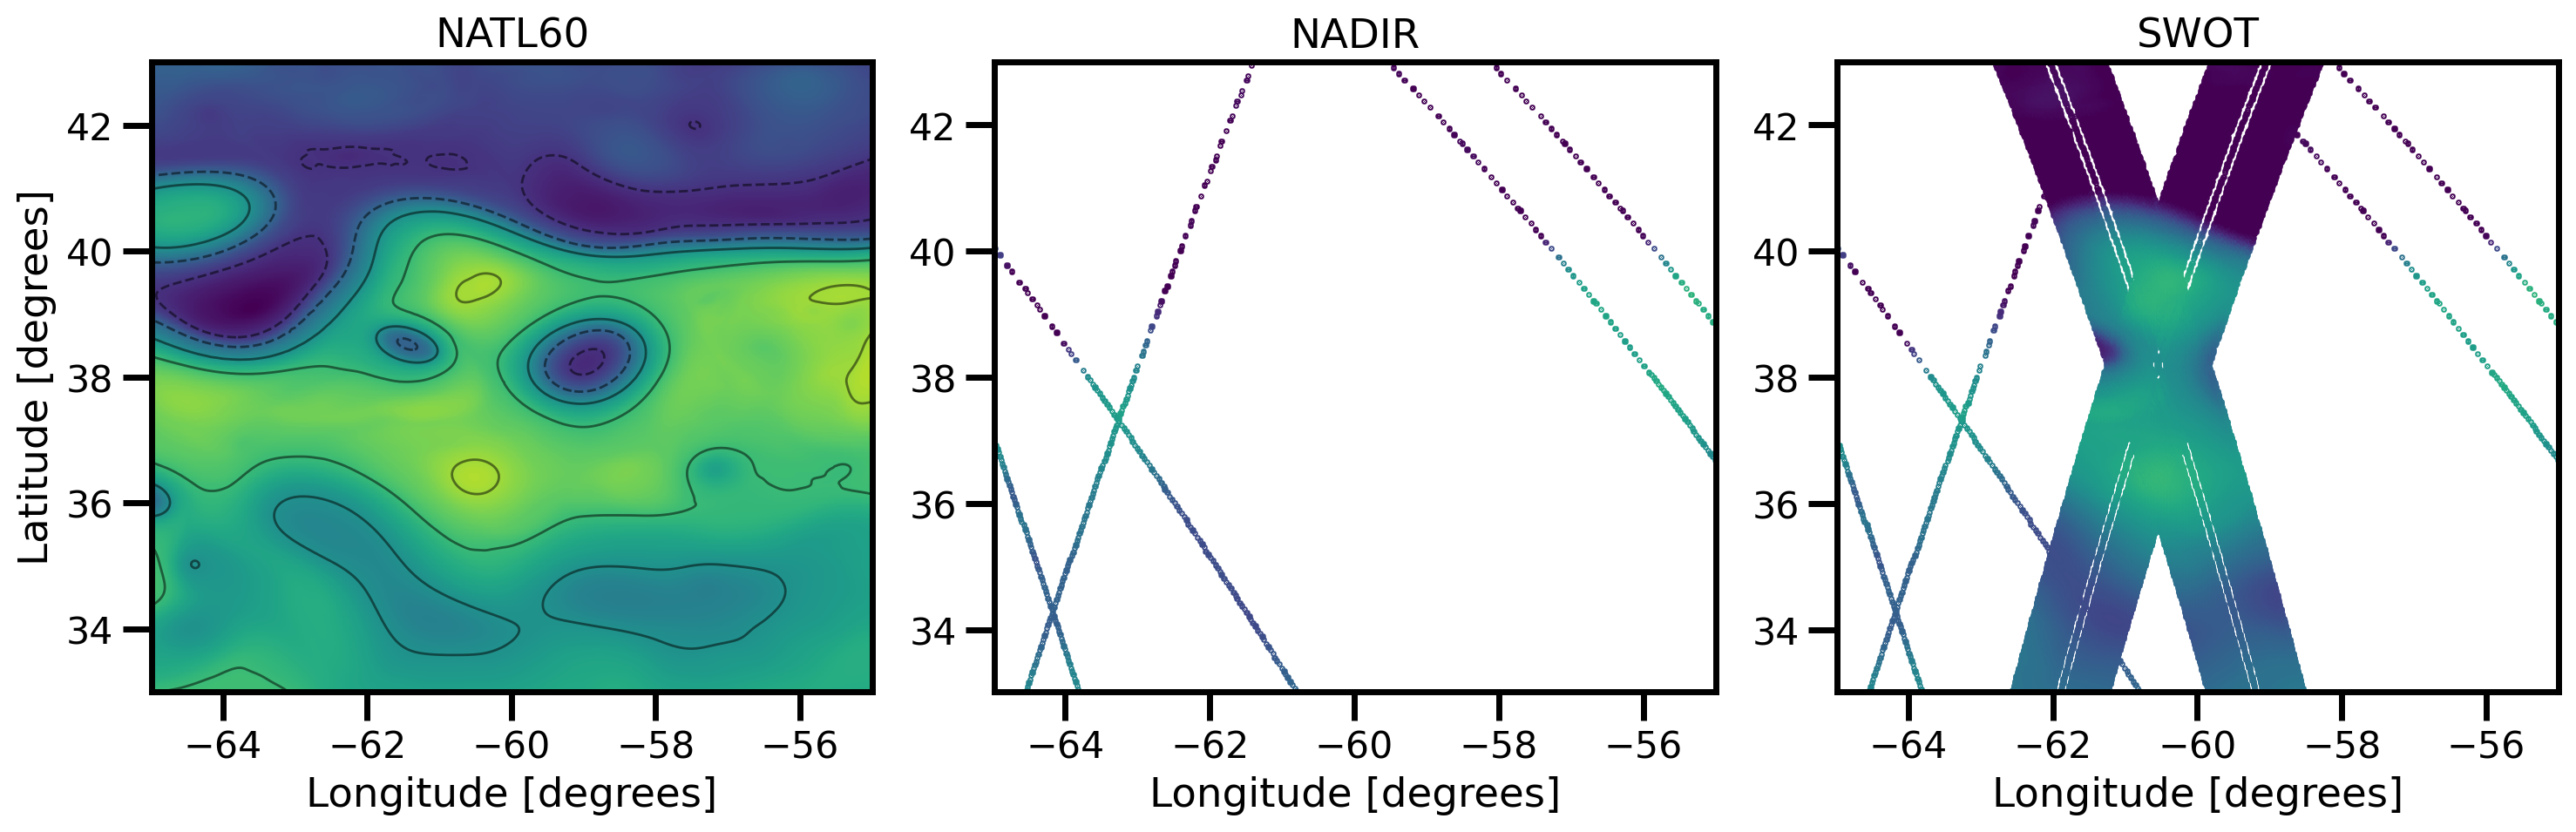

In [49]:
%matplotlib inline


mov = Movie(
    temp_ds, 
    plotfunc=custom_plot_ssh_together, 
    framedim="time", xlim=xlim, ylim=ylim,
    vmin=vmin, vmax=vmax,
    input_check=False
)
mov.preview(5)

In [50]:
fig_path = "./figures/dc20a/movies"

In [51]:
vmin, vmax = ds_natl60_anomaly.min(), ds_natl60_anomaly.max()

create_movie(
    temp_ds.chunk({'time':1}), #.sel(time=slice("2017-02-01", "2017-03-01")),
    name="dc20a_natl60_nadir_swot_ssh",
    plotfunc=custom_plot_ssh_together,
    file_path=fig_path,
    framedim="time",
    vmin=vmin, vmax=vmax,
    robust=True,
    xlim=xlim, ylim=ylim
)

Movie created at movie_dc20a_natl60_nadir_swot_ssh.mp4
GIF created at figures/dc20a/movies/movie_dc20a_natl60_nadir_swot_ssh.gif


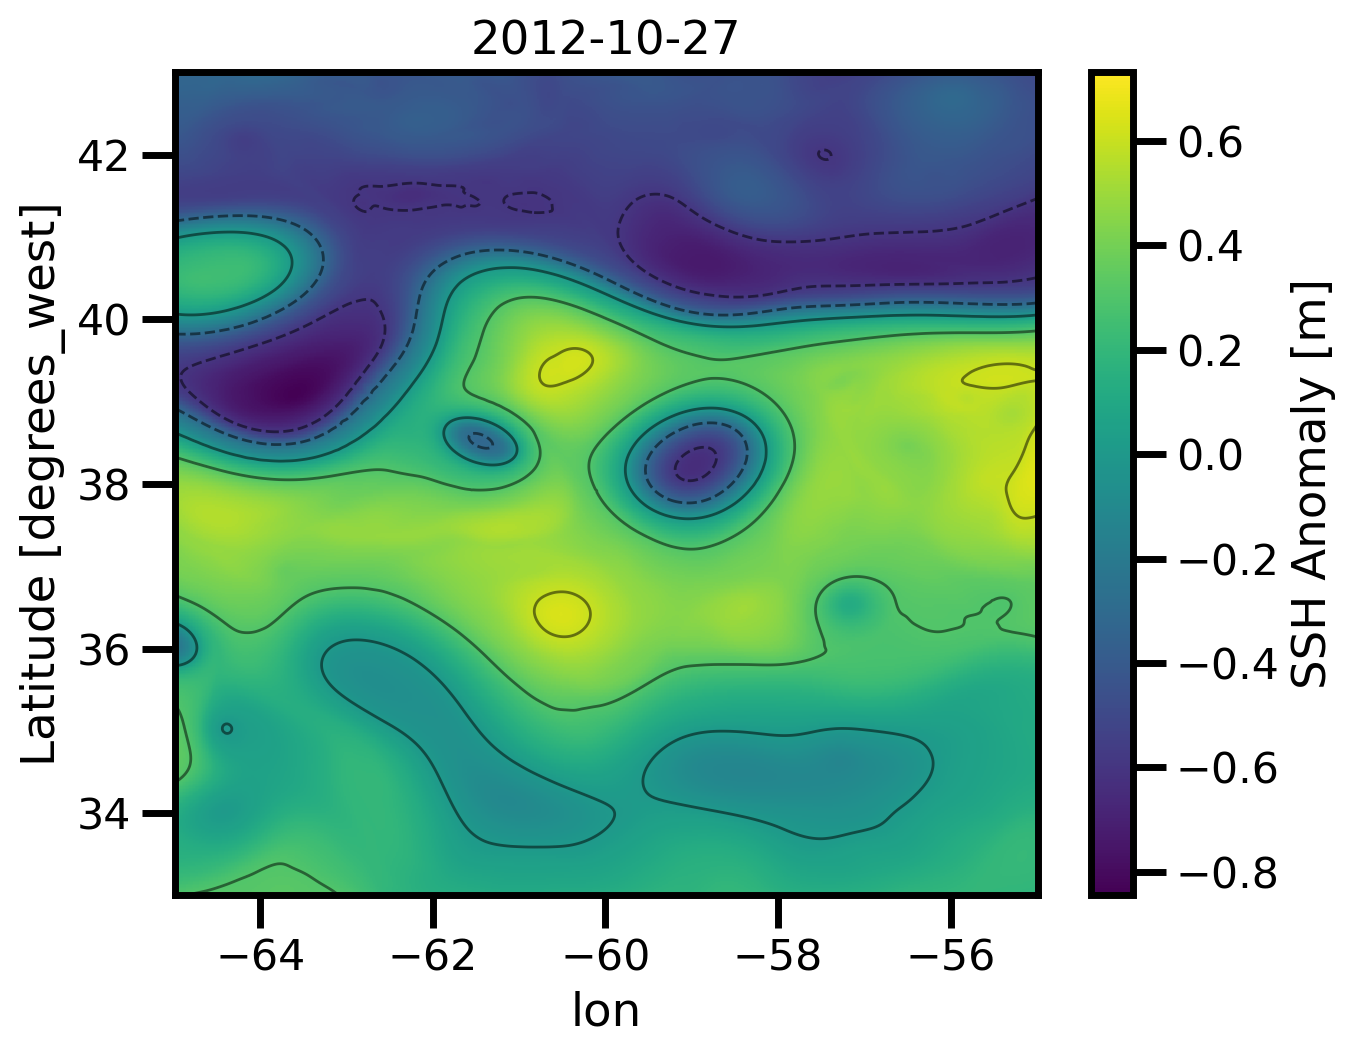

In [17]:
%matplotlib inline
cbar_kwargs = {"title": "SSH Anomaly [m]"}
ds_natl60_mean = ds_natl60.ssh - ds_natl60.ssh.mean(dim=["lat", "lon"])
vmin, vmax = ds_natl60_mean.min(), ds_natl60_mean.max()
mov = Movie(
    ds_natl60_mean, 
    plotfunc=custom_plot_ssh, 
    framedim="time", 
    rasterized=True,
    vmin=vmin, vmax=vmax
)
mov.preview(5)

In [50]:
ds_natl60_mean = ds_natl60.ssh.mean(dim=["lat", "lon"])
ds_natl60_anomaly = ds_natl60.ssh - ds_natl60_mean

In [19]:

vmin, vmax = ds_natl60_mean.min(), ds_natl60_mean.max()

create_movie(
    ds_natl60_mean.isel(time=slice(0,5)).chunk({'time':1}), #.sel(time=slice("2017-02-01", "2017-03-01")),
    name="dc20a_natl60_ssh",
    file_path=fig_path,
    framedim="time",
    # cbar_kwargs={"label": "Sea Surface Height ["},
    robust=True,
    vmin=vmin,
    vmax=vmax,
    rasterized=True,
)

Movie created at movie_dc20a_natl60_ssh.mp4
GIF created at figures/dc20a/movies/movie_dc20a_natl60_ssh.gif


In [25]:
vmin, vmax = ds_natl60_mean.min(), ds_natl60_mean.max()
xlim = [ds_natl60_mean.lon.min().values, ds_natl60_mean.lon.max().values]
ylim = [ds_natl60_mean.lat.min().values, ds_natl60_mean.lat.max().values]
ds_nadir4_anomaly = ds_nadir4.ssh - ds_natl60_mean

create_movie(
    ds_nadir4_anomaly.chunk({'time':1}), #.sel(time=slice("2017-02-01", "2017-03-01")),
    name="dc20a_nadir_ssh",
    plotfunc=custom_plot_ssh_obs,
    file_path=fig_path,
    framedim="time",
    vmin=vmin,
    vmax=vmax,
    robust=True,
    xlim=xlim,
    ylim=ylim,
)

/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xmovie/core.py:339: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=[self.width, self.height])


Movie created at movie_dc20a_nadir_ssh.mp4
GIF created at figures/dc20a/movies/movie_dc20a_nadir_ssh.gif


In [27]:
vmin, vmax = ds_natl60_mean.min(), ds_natl60_mean.max()
xlim = [ds_natl60_mean.lon.min().values, ds_natl60_mean.lon.max().values]
ylim = [ds_natl60_mean.lat.min().values, ds_natl60_mean.lat.max().values]
ds_swot1nadir5_anomaly = ds_swot1nadir5.ssh - ds_natl60_mean

create_movie(
    ds_swot1nadir5_anomaly.chunk({'time':1}), #.sel(time=slice("2017-02-01", "2017-03-01")),
    name="dc20a_swot1nadir5_ssh",
    plotfunc=custom_plot_ssh_obs,
    file_path=fig_path,
    framedim="time",
    vmin=vmin,
    vmax=vmax,
    robust=True,
    xlim=xlim,
    ylim=ylim,
)

/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xmovie/core.py:339: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=[self.width, self.height])


Movie created at movie_dc20a_swot1nadir5_ssh.mp4
GIF created at figures/dc20a/movies/movie_dc20a_swot1nadir5_ssh.gif


In [51]:
ds_natl60_mean = ds_natl60.ssh.mean(dim=["lat", "lon"])
ds_natl60_anomaly = ds_natl60.ssh - ds_natl60_mean
xlim = [ds_natl60_anomaly.lon.min().values, ds_natl60_anomaly.lon.max().values]
ylim = [ds_natl60_anomaly.lat.min().values, ds_natl60_anomaly.lat.max().values]
vmin, vmax = ds_natl60_anomaly.min(), ds_natl60_anomaly.max()

create_movie(
    ds_natl60_anomaly.chunk({'time':1}), #.sel(time=slice("2017-02-01", "2017-03-01")),
    name=f"dc20a_natl60_ssh",
    file_path=fig_path,
    framedim="time",
    vmin=vmin,
    vmax=vmax,
    robust=True,
    xlim=xlim, ylim=ylim
)

/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xmovie/core.py:339: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=[self.width, self.height])


Movie created at movie_dc20a_natl60_ssh.mp4
GIF created at figures/dc20a/movies/movie_dc20a_natl60_ssh.gif


In [52]:
ds_duacs_anomaly = ds_duacs.ssh - ds_duacs.ssh.mean(dim=["lat", "lon"])

# DUACS
create_movie(
    ds_duacs_anomaly.chunk({'time':1}), #.sel(time=slice("2017-02-01", "2017-03-01")),
    name=f"dc20a_duacs_ssh_{experiment}",
    file_path=fig_path,
    framedim="time",
    vmin=vmin,
    vmax=vmax,
    robust=True,
    xlim=xlim, ylim=ylim
)


/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xmovie/core.py:339: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=[self.width, self.height])


Movie created at movie_dc20a_duacs_ssh_nadir.mp4
GIF created at figures/dc20a/movies/movie_dc20a_duacs_ssh_nadir.gif


In [53]:
ds_miost_anomaly = ds_miost.ssh - ds_miost.ssh.mean(dim=["lat", "lon"])

# MIOST
create_movie(
    ds_miost_anomaly.chunk({'time':1}), #.sel(time=slice("2017-02-01", "2017-03-01")),
    name=f"dc20a_miost_ssh_{experiment}",
    file_path=fig_path,
    framedim="time",
    vmin=vmin, vmax=vmax,
    robust=True,
    xlim=xlim, ylim=ylim
)

/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xmovie/core.py:339: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=[self.width, self.height])


Movie created at movie_dc20a_miost_ssh_nadir.mp4
GIF created at figures/dc20a/movies/movie_dc20a_miost_ssh_nadir.gif


In [54]:
ds_nerf_mlp_anomaly = ds_nerf_mlp.ssh - ds_nerf_mlp.ssh.mean(dim=["lat", "lon"])

# NerF - MLP
create_movie(
    ds_nerf_mlp_anomaly.chunk({'time':1}), #.sel(time=slice("2017-02-01", "2017-03-01")),
    name=f"dc20a_nerf_mlp_ssh_{experiment}",
    file_path=fig_path,
    framedim="time",
    vmin=vmin, vmax=vmax,
    robust=True,
    xlim=xlim, ylim=ylim
)

/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xmovie/core.py:339: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=[self.width, self.height])


Movie created at movie_dc20a_nerf_mlp_ssh_nadir.mp4
GIF created at figures/dc20a/movies/movie_dc20a_nerf_mlp_ssh_nadir.gif


In [55]:
ds_nerf_ffn_anomaly = ds_nerf_ffn.ssh - ds_nerf_ffn.ssh.mean(dim=["lat", "lon"])

# NerF - FFN
create_movie(
    ds_nerf_ffn_anomaly.chunk({'time':1}), #.sel(time=slice("2017-02-01", "2017-03-01")),
    name=f"dc20a_nerf_ffn_ssh_{experiment}",
    file_path=fig_path,
    framedim="time",
    vmin=vmin, vmax=vmax,
    robust=True,
    xlim=xlim, ylim=ylim
)

/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xmovie/core.py:339: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=[self.width, self.height])


Movie created at movie_dc20a_nerf_ffn_ssh_nadir.mp4
GIF created at figures/dc20a/movies/movie_dc20a_nerf_ffn_ssh_nadir.gif


In [56]:
ds_nerf_siren_anomaly = ds_nerf_siren.ssh - ds_nerf_siren.ssh.mean(dim=["lat", "lon"])


# NerF - FFN
create_movie(
    ds_nerf_siren_anomaly.chunk({'time':1}), #.sel(time=slice("2017-02-01", "2017-03-01")),
    name=f"dc20a_nerf_siren_ssh_{experiment}",
    file_path=fig_path,
    framedim="time",
    vmin=vmin, vmax=vmax,
    robust=True,
    xlim=xlim, ylim=ylim
)

/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xmovie/core.py:339: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=[self.width, self.height])


Movie created at movie_dc20a_nerf_siren_ssh_nadir.mp4
GIF created at figures/dc20a/movies/movie_dc20a_nerf_siren_ssh_nadir.gif
